# 시나리오#1

### 웹 스크래핑, 크롤러
- 분단위 평균 기록횟수를 훌쩍 넘어가는 특정 시간대를 추출하여 리스팅
- 추출된 특정 시간대에서 사용된 UA 중 특수한 UA가 있는지 추출
- 추출된 특정 시간대에서 일반적인 접속량을 훌쩍 넘기는 Host 추출하여 리스팅
- 추출된 10개 Host의 패턴 분석 (Referer, Path, Bytes, 머무는 시간 등)
- 발견된 패턴대로 다른 Host에 대입하여 웹 스크래핑 입증

In [5]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('../dataset/track1.csv') # 데이터 프레임 초기화
df.Timestamp = pd.to_datetime(df.Timestamp) 
df = df[df['Status'].astype(str).str.isnumeric()] # 이상치 제거
df['Timestamp'] = df['Timestamp'].dt.strftime('%Y-%m-%d %H:%M') # 시계열 데이터를 1분 단위로 설정
df.head()

,Timestamp,Method,Protocol,Status,Referer,Path,Host,UA,Payload,Bytes
0,2020-08-24 10:00,GET,HTTP/1.1,200,"""-""",/1000/wp-includes/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6226.0
1,2020-08-24 10:00,GET,HTTP/1.1,200,"""-""",/1000/wp-login/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6226.0
2,2020-08-24 10:00,GET,HTTP/1.1,200,"""-""",/1000/wp-register/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6232.0
3,2020-08-24 10:00,GET,HTTP/1.1,200,"""-""",/1000/wp/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6248.0
4,2020-08-24 10:00,GET,HTTP/1.1,200,"""-""",/1000/wp-content/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6224.0


In [6]:
time_grp = df.groupby(['Timestamp'])
time_grp.count()

,Method,Protocol,Status,Referer,Path,Host,UA,Payload,Bytes
Timestamp,,,,,,,,,
2020-08-24 10:00,9,9,9,9,9,9,9,9,9
2020-08-24 10:01,11,11,11,11,11,11,11,11,11
2020-08-24 10:02,28,28,28,28,28,28,28,28,28
2020-08-24 10:03,38,38,38,38,38,38,38,38,38
2020-08-24 10:04,31,31,31,31,31,31,31,31,31
...,...,...,...,...,...,...,...,...,...
2020-08-28 19:42,48,48,48,48,48,48,48,48,48
2020-08-28 19:43,49,49,49,49,49,48,49,49,49
2020-08-28 19:44,54,54,54,54,54,54,54,54,54


# 분당 개별 유니크 호스트 수와 분당 가장 기록을 많이 남긴 호스트

In [7]:
funcHostUnique = lambda x: len(x['Host'].unique())
funcHostUniqueFirstValue = lambda x: x['Host'].value_counts()[0]
hostUnique = time_grp.apply(funcHostUnique)
hostUniqueFirstValue = time_grp.apply(funcHostUniqueFirstValue)

In [8]:
hostUniqueByMinute = pd.concat([(time_grp['Host'].count().rename('Count')), 
                      hostUnique.rename('HostUnq'), hostUniqueFirstValue.rename('HostFirstValue')], axis=1)

In [9]:
hostUniqueByMinute['HostUnq'].describe()

count    3822.000000
mean       81.928048
std        77.702654
min         1.000000
25%        35.000000
50%        66.000000
75%        75.000000
max       295.000000
Name: HostUnq, dtype: float64

In [10]:
hostUniqueByMinute['HostFirstValue'].describe()

count    3822.000000
mean       47.258503
std       162.658980
min         1.000000
25%         3.000000
50%         4.000000
75%        44.000000
max      3437.000000
Name: HostFirstValue, dtype: float64

In [131]:
hostUniqueByMinute[hostUniqueByMinute['HostFirstValue'] > 900]['HostUnq']

Timestamp
2020-08-27 14:47    248
2020-08-27 14:48    245
2020-08-27 14:50    241
2020-08-27 14:49    240
2020-08-27 14:51    238
2020-08-26 17:35     79
2020-08-26 17:37     79
2020-08-26 17:38     79
2020-08-26 17:36     75
2020-08-26 17:39     72
2020-08-25 10:21     38
2020-08-25 10:19     34
2020-08-25 10:20     33
2020-08-24 16:31     33
2020-08-24 10:42     19
2020-08-24 10:41     14
Name: HostUnq, dtype: int64

In [11]:
hostUniqueByMinute.index = pd.to_datetime(hostUniqueByMinute.index)

# 개별 호스트 유니크 수가 많은 인위적인 시간 패턴이 존재한다.
- 하나의 호스트가 혼자 많은 접근을 시도하는 경우는 시간상을 찾을 수 없다.
- 여러개의 호스트가 평균보다 많은 접근을 시도하는 경우는 시계열 상에 인위적인 패턴으로 등장한다.

## 24일 패턴 없음

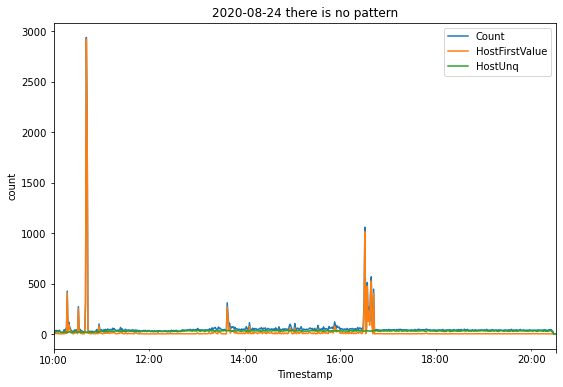

In [105]:
plt.figure(figsize=(9,6))
hostUniqueByMinute['2020-08-24 09:00':'2020-08-24 23:00']['Count'].sort_index().plot()
hostUniqueByMinute['2020-08-24 09:00':'2020-08-24 23:00']['HostFirstValue'].sort_index().plot()
hostUniqueByMinute['2020-08-24 09:00':'2020-08-24 23:00']['HostUnq'].sort_index().plot()
plt.title('2020-08-24 there is no pattern')
plt.ylabel('count')
plt.legend()
plt.show()

## 25일 총 8번 개별 호스트의 유니크 수가 급격히 늘어나는 패턴을 보임

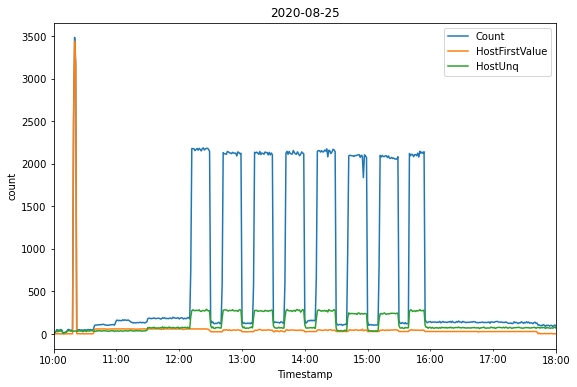

In [202]:
plt.figure(figsize=(9,6))
hostUniqueByMinute['2020-08-25 09:00':'2020-08-25 18:00']['Count'].sort_index().plot()
hostUniqueByMinute['2020-08-25 09:00':'2020-08-25 18:00']['HostFirstValue'].sort_index().plot()
hostUniqueByMinute['2020-08-25 09:00':'2020-08-25 18:00']['HostUnq'].sort_index().plot()
plt.title('2020-08-25')
plt.ylabel('count')
plt.legend()
plt.show()

## 26일 총 8번 개별 호스트의 유니크 수가 급격히 늘어나는 패턴을 보임

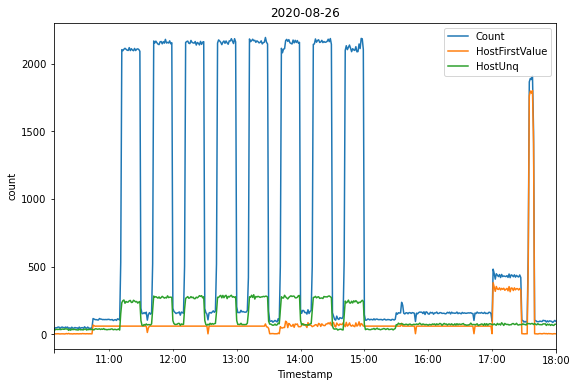

In [201]:
plt.figure(figsize=(9,6))
hostUniqueByMinute['2020-08-26 09:00':'2020-08-26 18:00']['Count'].sort_index().plot()
hostUniqueByMinute['2020-08-26 09:00':'2020-08-26 18:00']['HostFirstValue'].sort_index().plot()
hostUniqueByMinute['2020-08-26 09:00':'2020-08-26 18:00']['HostUnq'].sort_index().plot()
plt.title('2020-08-26')
plt.ylabel('count')
plt.legend()
plt.show()

## 27일 총 8번 개별 호스트의 유니크 수가 급격히 늘어나는 패턴을 보임 (26일과 패턴이 똑같다)

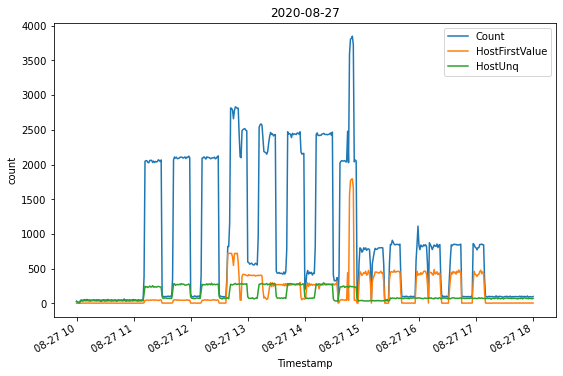

In [209]:
plt.figure(figsize=(9,6))
hostUniqueByMinute['2020-08-27 09:00':'2020-08-27 18:00']['Count'].sort_index().plot()
hostUniqueByMinute['2020-08-27 09:00':'2020-08-27 18:00']['HostFirstValue'].sort_index().plot()
hostUniqueByMinute['2020-08-27 09:00':'2020-08-27 18:00']['HostUnq'].sort_index().plot()
plt.title('2020-08-27')
plt.ylabel('count')
plt.legend()
plt.show()

## 28일 총 6번 개별 호스트의 유니크 수가 급격히 늘어나는 패턴을 보임 (비슷한 패턴을 보인다)

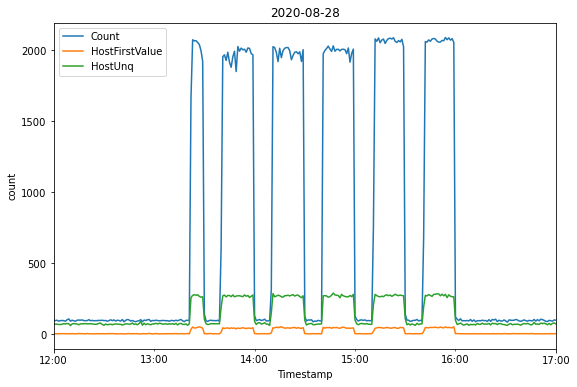

In [109]:
plt.figure(figsize=(9,6))
hostUniqueByMinute['2020-08-28 12:00':'2020-08-28 17:00']['Count'].sort_index().plot()
hostUniqueByMinute['2020-08-28 12:00':'2020-08-28 17:00']['HostFirstValue'].sort_index().plot()
hostUniqueByMinute['2020-08-28 12:00':'2020-08-28 17:00']['HostUnq'].sort_index().plot()
plt.title('2020-08-28')
plt.ylabel('count')
plt.legend()
plt.show()

# 호스트가 단독으로 많이 들어오는 경우에는 시간에 따른 패턴이 없다.

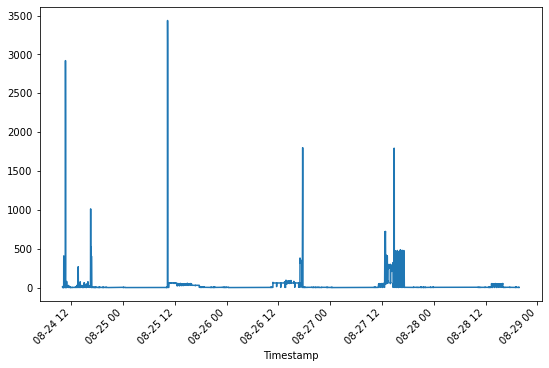

In [39]:
plt.figure(figsize=(9,6))
hostUniqueByMinute['HostFirstValue'].sort_index().plot()
plt.xticks(rotation=45)
plt.show()

# 28일에 발생한 패턴을 집중 분석해보자
- 13:39에서 13:40으로 넘어가는 순간 호스트가 100개 이상 증가한다.
- 13:41부터 13:59까지 평균 270개 정도의 호스트가 유지된다
- 호스트가 증가한 시점에서 접근량이 높은 50개의 호스트는 항상 일정하다.

In [270]:
df = pd.read_csv('../dataset/track1.csv', index_col='Timestamp')
df.index = pd.to_datetime(df.index)
df = df[df['Status'].astype(str).str.isnumeric()]
df.head()

,Method,Protocol,Status,Referer,Path,Host,UA,Payload,Bytes
Timestamp,,,,,,,,,
2020-08-24 10:00:18,GET,HTTP/1.1,200,"""-""",/1000/wp-includes/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6226.0
2020-08-24 10:00:18,GET,HTTP/1.1,200,"""-""",/1000/wp-login/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6226.0
2020-08-24 10:00:18,GET,HTTP/1.1,200,"""-""",/1000/wp-register/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6232.0
2020-08-24 10:00:18,GET,HTTP/1.1,200,"""-""",/1000/wp/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6248.0
2020-08-24 10:00:19,GET,HTTP/1.1,200,"""-""",/1000/wp-content/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6224.0


In [271]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1537008 entries, 2020-08-24 10:00:18 to 2020-08-28 19:46:37
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Method    1537008 non-null  object 
 1   Protocol  1537008 non-null  object 
 2   Status    1537008 non-null  object 
 3   Referer   1536523 non-null  object 
 4   Path      1537008 non-null  object 
 5   Host      1532423 non-null  object 
 6   UA        1537008 non-null  object 
 7   Payload   1537008 non-null  object 
 8   Bytes     1536682 non-null  float64
dtypes: float64(1), object(8)
memory usage: 117.3+ MB


In [297]:
anomalyPatternDay25 = df['2020-08-25']
anomalyPatternDay26 = df['2020-08-26']
anomalyPatternDay27 = df['2020-08-27']
anomalyPatternDay28 = df['2020-08-28']

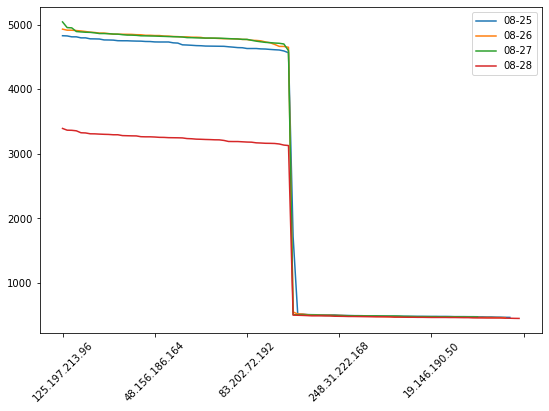

In [360]:
labels = ['08-25','08-26','08-27','08-28']
plt.figure(figsize=(9,6))
anomalyPatternDay25['Host'].value_counts()[2:100].plot()
anomalyPatternDay26['Host'].value_counts()[3:100].plot()
anomalyPatternDay27['Host'].value_counts()[9:100].plot()
anomalyPatternDay28['Host'].value_counts()[0:100].plot()
plt.legend(labels)
plt.xticks(rotation=45)
plt.show()

In [337]:
hostUniqueByMinute[hostUniqueByMinute['HostUnq'] > 200]['2020-08-25'].index.unique()[:50]

DatetimeIndex(['2020-08-25 12:11:00', '2020-08-25 12:12:00',
               '2020-08-25 12:13:00', '2020-08-25 12:14:00',
               '2020-08-25 12:15:00', '2020-08-25 12:16:00',
               '2020-08-25 12:17:00', '2020-08-25 12:18:00',
               '2020-08-25 12:19:00', '2020-08-25 12:20:00',
               '2020-08-25 12:21:00', '2020-08-25 12:22:00',
               '2020-08-25 12:23:00', '2020-08-25 12:24:00',
               '2020-08-25 12:25:00', '2020-08-25 12:26:00',
               '2020-08-25 12:27:00', '2020-08-25 12:28:00',
               '2020-08-25 12:29:00', '2020-08-25 12:42:00',
               '2020-08-25 12:43:00', '2020-08-25 12:44:00',
               '2020-08-25 12:45:00', '2020-08-25 12:46:00',
               '2020-08-25 12:47:00', '2020-08-25 12:48:00',
               '2020-08-25 12:49:00', '2020-08-25 12:50:00',
               '2020-08-25 12:51:00', '2020-08-25 12:52:00',
               '2020-08-25 12:53:00', '2020-08-25 12:54:00',
               '2020-08-

In [350]:
hostUniqueByMinute[hostUniqueByMinute['HostUnq'] > 200]['2020-08-25']

,Count,HostUnq,HostFirstValue
Timestamp,,,
2020-08-25 12:11:00,741,203,60
2020-08-25 12:12:00,2178,274,60
2020-08-25 12:13:00,2177,285,60
2020-08-25 12:14:00,2177,279,60
2020-08-25 12:15:00,2154,273,60
...,...,...,...
2020-08-25 15:50:00,2147,287,43
2020-08-25 15:51:00,2124,273,46
2020-08-25 15:52:00,2137,276,44


In [352]:
hostUniqueByMinute[hostUniqueByMinute['HostUnq'] > 200]['2020-08-26']

,Count,HostUnq,HostFirstValue
Timestamp,,,
2020-08-26 11:12:00,2103,233,60
2020-08-26 11:13:00,2095,248,60
2020-08-26 11:14:00,2106,253,60
2020-08-26 11:15:00,2113,229,60
2020-08-26 11:16:00,2106,242,60
...,...,...,...
2020-08-26 14:55:00,2145,237,92
2020-08-26 14:56:00,2111,234,60
2020-08-26 14:57:00,2186,243,79


In [353]:
hostUniqueByMinute[hostUniqueByMinute['HostUnq'] > 200]['2020-08-27']

,Count,HostUnq,HostFirstValue
Timestamp,,,
2020-08-27 11:12:00,2046,246,43
2020-08-27 11:13:00,2056,237,44
2020-08-27 11:14:00,2054,241,47
2020-08-27 11:15:00,2030,228,48
2020-08-27 11:16:00,2025,237,42
...,...,...,...
2020-08-27 14:50:00,3848,241,1794
2020-08-27 14:51:00,3726,238,1670
2020-08-27 14:52:00,2039,236,44


In [354]:
hostUniqueByMinute[hostUniqueByMinute['HostUnq'] > 200]['2020-08-28']

,Count,HostUnq,HostFirstValue
Timestamp,,,
2020-08-28 13:22:00,1661,258,35
2020-08-28 13:23:00,2075,274,51
2020-08-28 13:24:00,2067,279,44
2020-08-28 13:25:00,2068,275,45
2020-08-28 13:26:00,2056,278,49
...,...,...,...
2020-08-28 15:55:00,2075,258,47
2020-08-28 15:56:00,2088,278,48
2020-08-28 15:57:00,2072,268,47
